# <b> <font color='#A20025'> 📚 Chapter 5: Classification: Cytochrome P450 Inhibition

*This notebook contains the code examples in chapter 5. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH05_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers
- How to use machine learning to model metabolism via Cytochrome P450 inhibition
- Fundamental classification models such as logistic regression and decision trees
- Ensemble learning with bagging and random forests
- Different evaluation methods for classification problems
- Additional methods for model interpretation and applicability domain assessment

## <b> <font color='#A20025'> ⚙️ Environment Setup 

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
CHAPTER = "ch05"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch05/cyp_inhibitor_df.pkl" -O "artifacts/ch05/cyp_inhibitor_df.pkl"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch05/cyp3a4_train.pkl.gz" -O "artifacts/ch05/cyp3a4_train.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch05/cyp3a4_valid.pkl.gz" -O "artifacts/ch05/cyp3a4_valid.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/artifacts/ch05/cyp3a4_test.pkl.gz" -O "artifacts/ch05/cyp3a4_test.pkl.gz"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/ml4dd2025.yml" -O "env.yml"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/utils.py" -O "utils.py"

In [ ]:
# Colab users only
!pip install -q condacolab
import condacolab
condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab users only
# Verify condalab installation
import condacolab
condacolab.check()

In [ ]:
# Colab users only
# We can only use the base environment in `condacolab`, so we will update it with the `env.yml` file we downloaded earlier.
!mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [ ]:
# Core packages
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import seaborn as sns
from pathlib import Path
from tempfile import TemporaryDirectory
from zipfile import ZipFile
from tqdm.auto import tqdm

# Machine learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, matthews_corrcoef, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    coverage_error, multilabel_confusion_matrix, 
    label_ranking_loss, classification_report,
    ConfusionMatrixDisplay, average_precision_score
)

from sklearn.multioutput import MultiOutputClassifier
from skmultilearn.model_selection import IterativeStratification

# Chemical informatics packages
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, MolToInchi, MolFromInchi
from rdkit import DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# Utility functions
from utils import (
    save_molecular_dataframe,
    load_molecular_dataframe,
    list_saved_dataframes,
)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [59]:
# Visualization styles
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    colors = ["#A20025", "#6C8EBF", "#F9CBCD", "#D4E1F5", "#A680B8", "#C3ABD0", "#12AAB5", "#9AC7BF"]  # Define a color palette
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16

setup_visualization_style()
%matplotlib inline

In [3]:
# RDKit drawing setup
def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15
    dopts.dotsPerAngstrom = 100
    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

## <b> <font color='#A20025'> 1️⃣ Binary Classification of CYP3A4 Inhibition

Cytochrome P450 3A4 (CYP3A4) is one of the most abundant drug-metabolizing enzyme in the human liver and is involved in the metabolism of approximately 50% of all marketed drugs. Inhibition of CYP3A4 can lead to drug-drug interactions, potentially causing adverse effects or reducing drug efficacy.
 
In this section, we'll build a binary classifier to predict whether a compound will inhibit CYP3A4.

### <b> <font color='#A20025'> Logistic Regression in Practice

We'll use the Veith et al. dataset from the Therapeutics Data Commons (TDC), which contains experimental data on CYP3A4 inhibition for a diverse set of compounds.

To avoid issues with installing TDC, I've provided the train, validation, and test files in `artifacts/ch05/`. If the files exist in `artifacts/ch05/`, then the load data function will laod those files instead of needing to import and download them from TDC. We recommend checking if the files exist and, if they don't, you can download them at the same location in this repository on GitHub.

In [4]:
def load_cyp_data(cyp_isoform="CYP3A4_Veith"):
    """
    Load CYP inhibition data from TDC.
    
    Parameters:
        cyp_isoform (str): Name of the CYP isoform dataset
        
    Returns:
        pandas.DataFrame: DataFrame containing the data
    """
    # Define paths for cached data
    cache_paths = {
        'train': f'artifacts/ch05/cyp3a4_train.pkl.gz',
        'valid': f'artifacts/ch05/cyp3a4_valid.pkl.gz',
        'test': f'artifacts/ch05/cyp3a4_test.pkl.gz'
    }
    
    # Check if cached data exists
    if all(os.path.exists(path) for path in cache_paths.values()):
        print(f"Loading {cyp_isoform} dataset from cached files...")
        train_df = load_molecular_dataframe("cyp3a4_train.pkl.gz", chapter="ch05")
        valid_df = load_molecular_dataframe("cyp3a4_valid.pkl.gz", chapter="ch05")
        test_df = load_molecular_dataframe("cyp3a4_test.pkl.gz", chapter="ch05")
        
        print(f"Loaded {cyp_isoform} cached dataset")
        print(f"Training set: {len(train_df)} compounds")
        print(f"Validation set: {len(valid_df)} compounds")
        print(f"Test set: {len(test_df)} compounds")
    else:
        # If cached data doesn't exist, load from TDC
        print(f"Cached data not found. Loading {cyp_isoform} dataset from TDC...")
        from tdc.single_pred import ADME
        
        data = ADME(name=cyp_isoform)
        splits = data.get_split('scaffold')
        
        print(f"Loaded dataset with {len(data)} total compounds")

        # Get the data splits
        train_df, valid_df, test_df = splits['train'], splits['valid'], splits['test']
        print(f"Loaded {cyp_isoform} dataset")
        print(f"Training set: {len(train_df)} compounds")
        print(f"Validation set: {len(valid_df)} compounds")
        print(f"Test set: {len(test_df)} compounds")
        
        # Create directory if it doesn't exist
        Path('artifacts/ch05').mkdir(parents=True, exist_ok=True)
        
        # Optional: Save the loaded data for future use
        # Uncomment if you want to cache the data after loading from TDC
        # save_molecular_dataframe(train_df, "cyp3a4_train.pkl.gz", chapter="ch05")
        # save_molecular_dataframe(valid_df, "cyp3a4_valid.pkl.gz", chapter="ch05")
        # save_molecular_dataframe(test_df, "cyp3a4_test.pkl.gz", chapter="ch05")
    
    return train_df, valid_df, test_df

# Load CYP3A4 data
train_df, valid_df, test_df = load_cyp_data()

# Display basic information
print("Training dataset information:")
display(train_df.info())

# Display the first few rows
print("First few rows of the training dataset:")
with pd.option_context('display.max_colwidth', None):
    display(train_df.head())

Loading CYP3A4_Veith dataset from cached files...
Loading molecular dataframe from artifacts/ch05/cyp3a4_train.pkl.gz...
Successfully loaded dataframe with 8629 rows and 3 columns
Loading time: 0.04 seconds
Loading molecular dataframe from artifacts/ch05/cyp3a4_valid.pkl.gz...
Successfully loaded dataframe with 1232 rows and 3 columns
Loading time: 0.01 seconds
Loading molecular dataframe from artifacts/ch05/cyp3a4_test.pkl.gz...
Successfully loaded dataframe with 2467 rows and 3 columns
Loading time: 0.01 seconds
Loaded CYP3A4_Veith cached dataset
Training set: 8629 compounds
Validation set: 1232 compounds
Test set: 2467 compounds
Training dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8629 entries, 0 to 8628
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  8629 non-null   float64
 1   Drug     8629 non-null   object 
 2   Y        8629 non-null   int64  
dtypes: float64(1), int64(1), obje

None

First few rows of the training dataset:


,Drug_ID,Drug,Y
0,6604143.0,NC(=O)C1=CN([C@@H]2O[C@@H](COP(=O)([O-])OP(=O)([O-])OC[C@@H]3O[C@H](n4cnc5c(N)ncnc54)[C@@H](OP(=O)([O-])[O-])[C@@H]3O)[C@H](O)[C@@H]2O)C=CC1.[Na+].[Na+].[Na+].[Na+],0
1,4577404.0,NS(=O)(=O)c1cccc2c1c([N+](=O)[O-])cc1nc([O-])c([O-])nc12,0
2,6098006.0,NS(=O)(=O)c1cccc2c1c([N+](=O)[O-])cc1nc([O-])c([O-])nc12.[Na+].[Na+],0
3,408613.0,COc1cc(CN2CCCCC2)cc2cc(C(=O)O)c(=O)oc12,0
4,9594267.0,CCOc1cc(/C=N/NC(=O)Cc2ccc(C(F)(F)F)cc2[N+](=O)[O-])c(Br)cc1OC,1


Let's convert the molecules to RDKit objects and generate Morgan fingerprints as features.

In [ ]:
# Define function to compute Morgan fingerprints
def compute_fingerprint(mol, radius=2, nBits=2048):
    """Generate Morgan fingerprint for a molecule"""
    morgan_generator = GetMorganGenerator(radius=radius, fpSize=nBits)
    if mol is None:
        return None
    return morgan_generator.GetFingerprintAsNumPy(mol)

def process_df(df, smiles_col="Drug"):
    """
    Process CYP data by adding RDKit molecules and fingerprints.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing SMILES strings
        smiles_col (str): Column name with SMILES strings
        
    Returns:
        tuple: (processed_df, fingerprints_array) Processed data
    """
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Rename columns for consistency
    df_copy = df_copy.rename(columns={'Y':'Inhibitor'})
    
    # Add RDKit molecule objects
    print("Converting SMILES to RDKit molecules...")
    PandasTools.AddMoleculeColumnToFrame(df_copy, smiles_col, "Molecule")
    
    # Drop rows with invalid molecules
    df_clean = df_copy.dropna(subset=["Molecule"])
    if len(df_clean) < len(df_copy):
        print(f"Dropped {len(df_copy) - len(df_clean)} rows with invalid molecules")
    
    # Add fingerprints to the dataframe
    print("Generating Morgan fingerprints...")
    df_clean['fingerprints'] = df_clean['Molecule'].apply(
        lambda x: compute_fingerprint(x) if x is not None else None
    )
    
    # Convert fingerprints to a numpy array
    fingerprints = np.vstack(df_clean['fingerprints'].values)

    print(f"Generated fingerprints with shape: {fingerprints.shape}")
    
    return df_clean, fingerprints

# Process each dataset
train_df_processed, train_fingerprints = process_df(train_df)
valid_df_processed, valid_fingerprints = process_df(valid_df)
test_df_processed, test_fingerprints = process_df(test_df)

# Check class distribution
print("\nClass distribution:")
print(f"Training set: {train_df_processed['Inhibitor'].value_counts()}")
print(f"Validation set: {valid_df_processed['Inhibitor'].value_counts()}")
print(f"Test set: {test_df_processed['Inhibitor'].value_counts()}")

Converting SMILES to RDKit molecules...
Generating Morgan fingerprints...
Generated fingerprints with shape: (8629, 2048)
Converting SMILES to RDKit molecules...
Generating Morgan fingerprints...
Generated fingerprints with shape: (1232, 2048)
Converting SMILES to RDKit molecules...
Generating Morgan fingerprints...
Generated fingerprints with shape: (2467, 2048)

Class distribution:
Training set: Inhibitor
0    5151
1    3478
Name: count, dtype: int64
Validation set: Inhibitor
0    682
1    550
Name: count, dtype: int64
Test set: Inhibitor
0    1385
1    1082
Name: count, dtype: int64


**Logistic Regression Baseline Model**

We'll start with a logistic regression model as a baseline for CYP3A4 inhibition prediction.


In [6]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    """
    Train a model and evaluate its performance
    
    Parameters:
    model: The sklearn model to train
    X_train, y_train: Training data
    X_val, y_val: Validation data
    model_name: Name of the model for reporting
    
    Returns:
    tuple: (trained_model, metrics_dict)
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'mcc': matthews_corrcoef(y_val, y_pred),
        'predictions': y_pred,
        'probabilities': y_proba
    }
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"MCC:       {metrics['mcc']:.4f}")
    
    return model, metrics

# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr_model, lr_metrics = train_and_evaluate_model(
    lr_model, 
    train_fingerprints, train_df_processed.Inhibitor,
    valid_fingerprints, valid_df_processed.Inhibitor,
    model_name="Logistic Regression"
)


Logistic Regression Performance:
Accuracy:  0.7808
Precision: 0.7612
Recall:    0.7418
F1 Score:  0.7514
MCC:       0.5557


Let's visualize the confusion matrix to understand the types of errors our model makes.

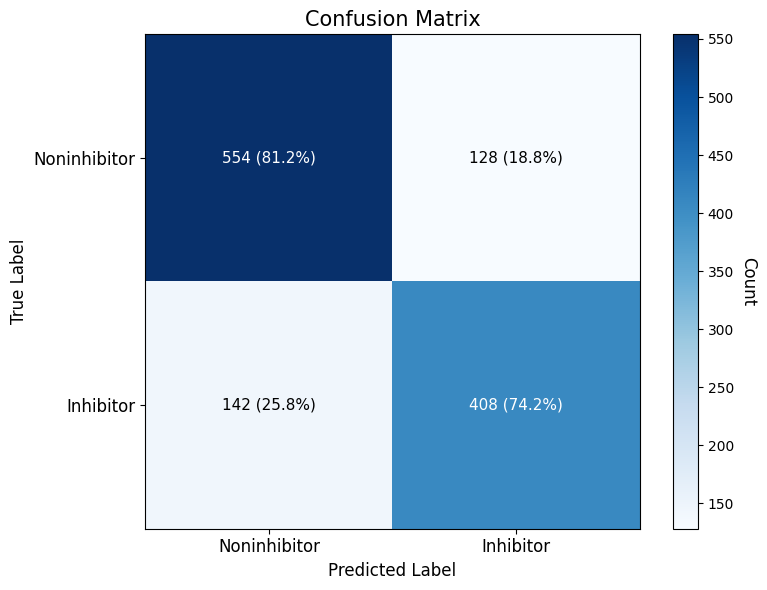

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    """Plot a confusion matrix with percentage annotations"""
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = cm_norm * 100
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    
    # Add title and labels
    ax.set_title('Confusion Matrix', fontsize=15)
    
    # Add class labels
    if class_names is None:
        class_names = ['Negative', 'Positive']
    
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names, fontsize=12)
    ax.set_yticklabels(class_names, fontsize=12)
    
    # Add axis labels
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    
    # Add text annotations
    fmt = '.1f' # Display as percentage with 1 decimal place
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax.text(j, i, f"{cm[i, j]} ({cm_percent[i, j]:{fmt}}%)",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=11)
    
    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Count', rotation=-90, va="bottom", fontsize=12)
    
    # Tight layout and return the figure
    fig.tight_layout()
    return fig

# Plot confusion matrix for logistic regression
cm_fig = plot_confusion_matrix(
    valid_df_processed.Inhibitor, 
    lr_metrics['predictions'],
    class_names=['Noninhibitor', 'Inhibitor']
)

### <b> <font color='#A20025'> Miscalibration: Questioning Probabilistic Output Assumptions

Classification models not only predict class labels but also output probability estimates. However, these probabilities may not be well-calibrated, meaning they might not represent true probabilities of class membership.

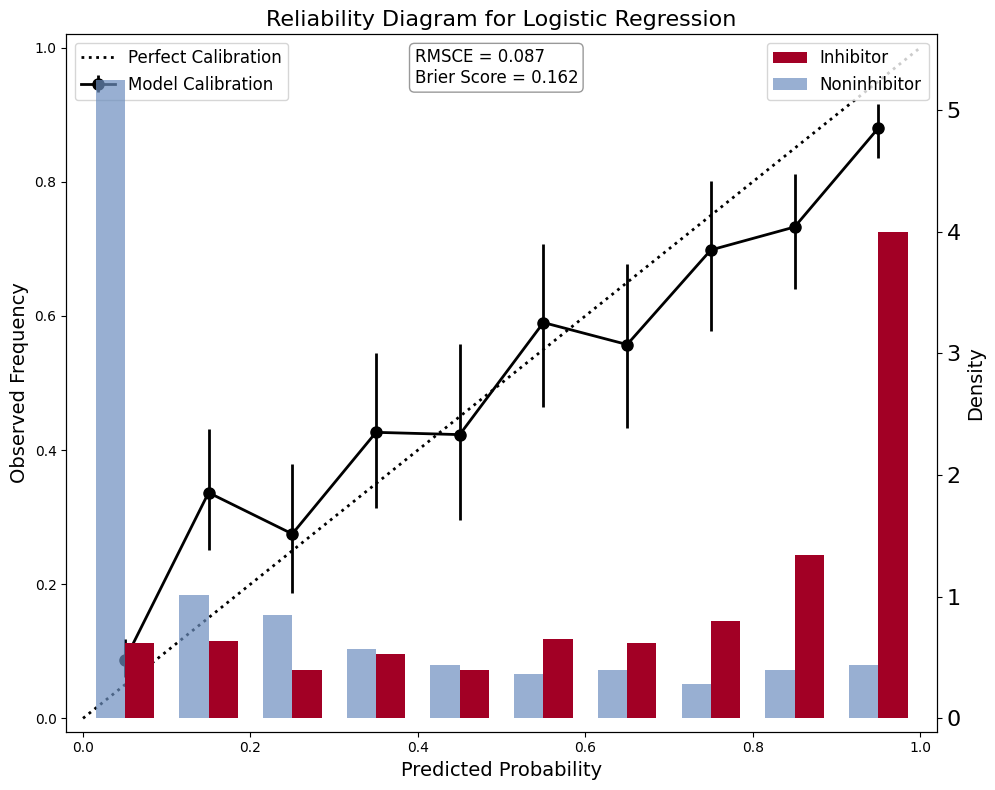

In [23]:
def r2(x, y):
    """Calculate R² (coefficient of determination) and p-value"""
    from scipy import stats
    return stats.pearsonr(x, y)[0] ** 2, stats.pearsonr(x, y)[1]

def binomial_errors(n1, n0, ci=0.95, eps=1e-6):
    """Calculate binomial confidence intervals"""
    from scipy import stats
    
    b = n0
    a = n1
    p = a / (a + b + eps)
    pad = (1. - ci) / 2.
    
    # Use beta distribution for confidence intervals
    B = stats.beta(a + 0.5, b + 0.5)
    
    low = -B.ppf(pad) + p
    high = B.ppf(1 - pad) - p
    
    return np.array([low, high]).T

def reliability_diagram(y, t, nbins=20, ax=None, bar_scale=0.7, pad=0.02, hist_format=None):
    """
    Create a reliability diagram (calibration curve)
    
    Parameters:
    y (array): Predicted probabilities
    t (array): True labels
    nbins (int): Number of bins
    ax: Matplotlib axis (optional)
    bar_scale (float): Width scaling for bars
    pad (float): Padding
    hist_format (dict): Format for histogram
    
    Returns:
    tuple: (ax, ax1) Primary and secondary axes
    """
    t = np.asarray(t)
    y = np.asarray(y)
    
    # Create bins
    bins = np.linspace(0.0, 1.0, nbins + 1, endpoint=True)
    
    # Count positives and negatives in each bin
    n1, bin_edge = np.histogram(y, bins, weights=t)
    n0, bin_edge = np.histogram(y, bins, weights=1.0 - t)
    
    # Calculate proportion of positives in each bin
    p = n1.astype(float) / (n1 + n0 + 1e-8)  # Add small epsilon to avoid division by zero
    
    # Get bin centers
    bin_center = (bin_edge[:-1] + bin_edge[1:]) / 2
    width = 0.5 / nbins * bar_scale
    
    # Calculate confidence intervals
    yerr = binomial_errors(n1, n0).T
    
    # Create plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    ax1 = ax.twinx()
    
    # Format for histogram
    if hist_format is None:
        hist_format = dict(edgecolor="white", linewidth=0)
    
    # Calculate density for histogram
    n1_density, _ = np.histogram(y, bins, weights=t, density=True)
    n0_density, _ = np.histogram(y, bins, weights=1.0 - t, density=True)
    
    # Plot histograms
    ax1.bar(bin_center + width/2, n1_density, width=width, align="center", 
            label="Inhibitor", color="#A20025", **hist_format)
    ax1.bar(bin_center - width/2, n0_density, width=width, align="center", 
            label="Noninhibitor", color="#6C8EBF", alpha=0.7, **hist_format)
    
    # Plot diagonal (perfect calibration)
    ax.plot([0, 1], [0, 1], 'k:', linewidth=2, label="Perfect Calibration")
    
    # Plot calibration curve
    try:
        ax.errorbar(bin_center, p, yerr, fmt='ko-', linewidth=2, markersize=8, label="Model Calibration")
    except:
        ax.plot(bin_center, p, 'ko-', linewidth=2, markersize=8, label="Model Calibration")
        print("Warning: Error bars could not be plotted")
    
    # Set labels and limits
    ax.set_ylabel('Observed Frequency', fontsize=14)
    ax.set_xlabel('Predicted Probability', fontsize=14)
    ax.set_xlim(-pad, 1 + pad)
    ax.set_ylim(-pad, 1 + pad)
    ax.legend(loc="upper left", fontsize=12)
    
    # Adjust second y-axis
    lim1 = ax1.get_ylim()
    pad1 = (lim1[1] - lim1[0]) * pad
    ax1.set_ylim(lim1[0] - pad1, lim1[1] + pad1)
    ax1.set_ylabel('Density', fontsize=14)
    ax1.legend(loc="upper right", fontsize=12)
    
    # Calculate Brier score (mean squared error of probabilities)
    brier_score = ((y - t) ** 2).mean()
    
    # Calculate RMSCE (Root Mean Squared Calibration Error)
    mask = ~np.isnan(p)
    p_mask = p[mask]
    bc_mask = bin_center[mask]
    rmsce = math.sqrt(((bc_mask - p_mask) ** 2).mean())
    
    # Add statistics to plot
    ax.text(0.4, 0.93, f"RMSCE = {rmsce:.3f}\nBrier Score = {brier_score:.3f}",
            transform=ax.transAxes, fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    return ax, ax1

# Plot reliability diagram for logistic regression
ax, ax1 = reliability_diagram(
    lr_metrics['probabilities'], 
    valid_df_processed.Inhibitor, 
    nbins=10
)
plt.title("Reliability Diagram for Logistic Regression", fontsize=16)
plt.tight_layout()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.tick_params(labelsize=16)
plt.savefig("figures/ch05/lr_model_reliability_diagram.pdf", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch05/lr_model_reliability_diagram.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch05/lr_model_reliability_diagram.png", bbox_inches='tight', dpi=600)

Let's apply two common probability calibration methods:
1. **Platt Scaling (Sigmoid)**: Applies a logistic regression to the model outputs
2. **Isotonic Regression**: Uses a non-parametric monotonic function for calibration


In [27]:
# Apply calibration methods
def apply_calibration(model, X_train, y_train, X_val, y_val):
    """Apply probability calibration methods to a classifier"""
    # Platt scaling (sigmoid calibration)
    platt_model = CalibratedClassifierCV(
        model, method='sigmoid', cv='prefit'
    )
    platt_model.fit(X_val, y_val)  # Use validation set to avoid overfitting
    
    # Isotonic regression calibration
    isotonic_model = CalibratedClassifierCV(
        model, method='isotonic', cv='prefit'
    )
    isotonic_model.fit(X_val, y_val)  # Use validation set to avoid overfitting
    
    # Get predictions
    y_proba_orig = model.predict_proba(X_val)[:, 1]
    y_proba_platt = platt_model.predict_proba(X_val)[:, 1]
    y_proba_isotonic = isotonic_model.predict_proba(X_val)[:, 1]
    
    # Calculate Brier scores
    brier_orig = ((y_proba_orig - y_val) ** 2).mean()
    brier_platt = ((y_proba_platt - y_val) ** 2).mean()
    brier_isotonic = ((y_proba_isotonic - y_val) ** 2).mean()
    
    return platt_model, isotonic_model

# Apply calibration to logistic regression model
lr_platt, lr_isotonic = apply_calibration(
    lr_model, 
    train_fingerprints, train_df_processed.Inhibitor,
    valid_fingerprints, valid_df_processed.Inhibitor
)

/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


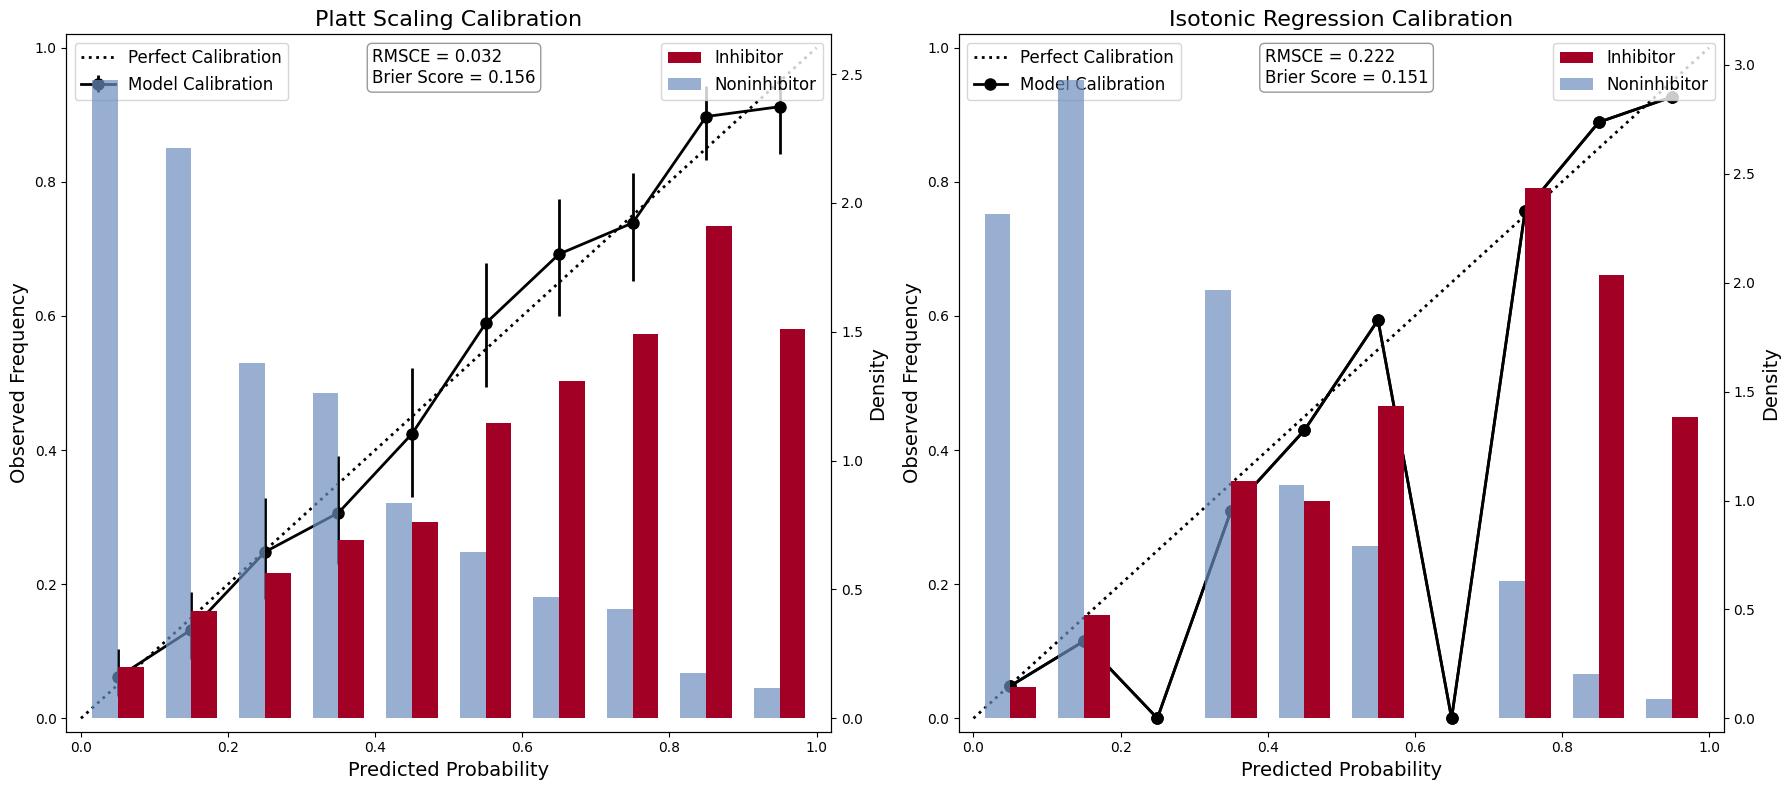

In [26]:
# Plot reliability diagrams for calibrated models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Platt scaling reliability diagram
reliability_diagram(
    lr_platt.predict_proba(valid_fingerprints)[:, 1],
    valid_df_processed.Inhibitor,
    nbins=10,
    ax=ax1
)
ax1.set_title("Platt Scaling Calibration", fontsize=16)

# Isotonic regression reliability diagram
reliability_diagram(
    lr_isotonic.predict_proba(valid_fingerprints)[:, 1],
    valid_df_processed.Inhibitor,
    nbins=10,
    ax=ax2
)
ax2.set_title("Isotonic Regression Calibration", fontsize=16)

plt.tight_layout()
plt.savefig("figures/ch05/calibration_comparison.png", bbox_inches='tight', dpi=600)

ROC and Precision-Recall curves are essential tools for evaluating classifier performance across different thresholds.

Optimal classification threshold: 0.4501


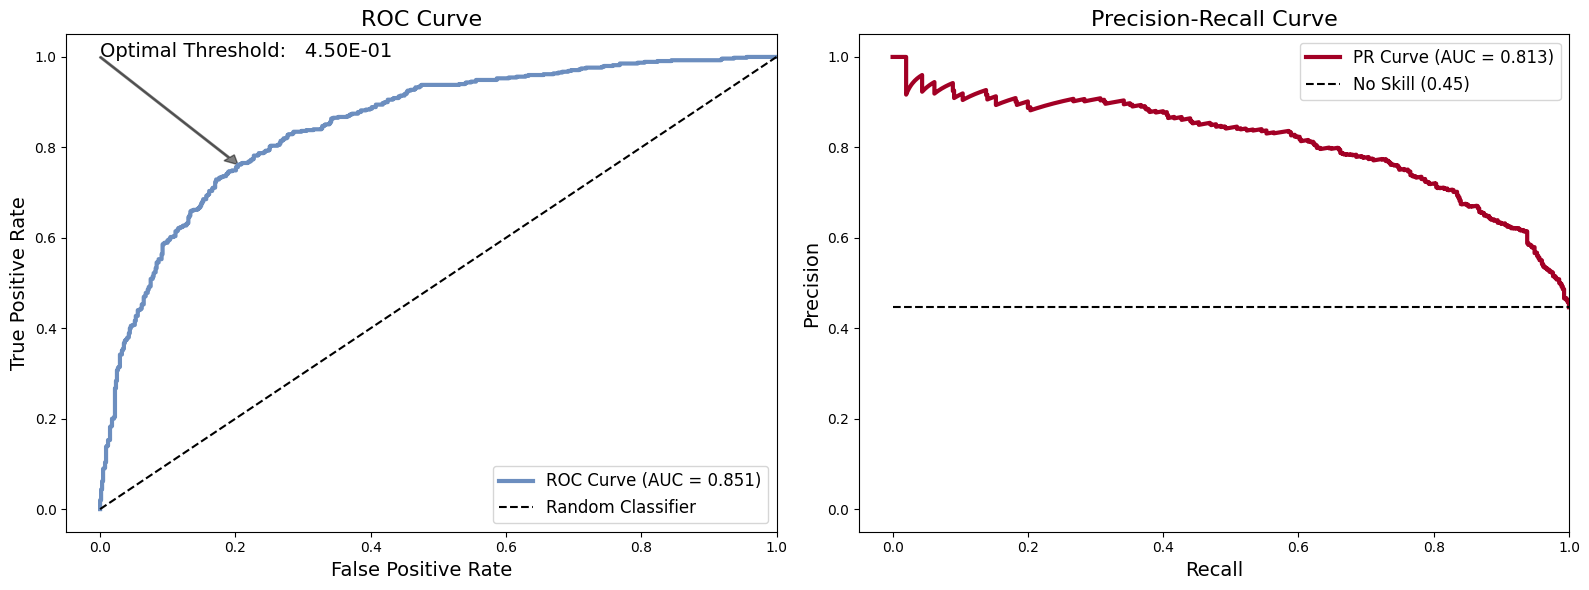

In [32]:
def plot_roc_pr_curves(y_true, y_score):
    """
    Plot ROC and Precision-Recall curves
    
    Parameters:
    y_true: True labels
    y_score: Predicted probabilities
    
    Returns:
    fig: Figure with plots
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    axes[0].plot(fpr, tpr, linewidth=3, color="#6C8EBF", label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[0].set_xlabel('False Positive Rate', fontsize=14)
    axes[0].set_ylabel('True Positive Rate', fontsize=14)
    axes[0].set_title('ROC Curve', fontsize=16)
    axes[0].legend(loc='lower right', fontsize=12)
    
    # Mark optimal threshold
    axes[0].arrow(0, 1, fpr[optimal_idx], -1*(1-tpr[optimal_idx]), color="black", alpha=0.5, length_includes_head=True, head_width=0.02, head_length=0.02, shape='full', width=0.003)
    axes[0].annotate("Optimal Threshold: {:10.2E}".format(optimal_threshold), (0., 1.), size=14)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    
    axes[1].plot(recall, precision, linewidth=3, color="#A20025", label=f'PR Curve (AUC = {pr_auc:.3f})')
    
    # Add no-skill (i.e., skew) line (class distribution)
    no_skill = np.mean(y_true)
    axes[1].plot([0, 1], [no_skill, no_skill], 'k--', label=f'No Skill ({no_skill:.2f})')
    
    axes[1].set_xlabel('Recall', fontsize=14)
    axes[1].set_ylabel('Precision', fontsize=14)
    axes[1].set_title('Precision-Recall Curve', fontsize=16)
    axes[1].legend(loc='upper right', fontsize=12)
    
    # Set axis limits
    axes[0].axis([-0.05, 1.0, -0.05, 1.05])
    axes[1].axis([-0.05, 1.0, -0.05, 1.05])

    plt.tight_layout()
    
    return fig, optimal_threshold

# Plot ROC and PR curves for logistic regression
roc_pr_fig, optimal_threshold = plot_roc_pr_curves(
    valid_df_processed.Inhibitor, 
    lr_metrics['probabilities']
)
plt.savefig("figures/ch05/roc_and_pr_curves.png", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch05/roc_and_pr_curves.pdf", bbox_inches='tight', dpi=600)

print(f"Optimal classification threshold: {optimal_threshold:.4f}")

## <b> <font color='#A20025'> 2️⃣ Tree-based Models

Decision trees offer an interpretable alternative to logistic regression and can capture non-linear relationships in the data.

### <b> <font color='#A20025'> Decision Trees

To aid visualization and interpretation, we'll first train a decision tree using basic molecular descriptors.

In [33]:
def calculate_molecular_descriptors(df, mol_col="Molecule"):
    """Calculate basic molecular descriptors"""
    from rdkit.Chem import Descriptors
    
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Calculate descriptors
    df_copy['MolWt'] = df_copy[mol_col].apply(lambda m: Descriptors.MolWt(m) if m is not None else None)
    df_copy['logP'] = df_copy[mol_col].apply(lambda m: Descriptors.MolLogP(m) if m is not None else None)
    
    # Drop rows with missing values
    df_clean = df_copy.dropna(subset=['MolWt', 'logP'])
    
    return df_clean

# Calculate descriptors
train_desc = calculate_molecular_descriptors(train_df_processed)
valid_desc = calculate_molecular_descriptors(valid_df_processed)

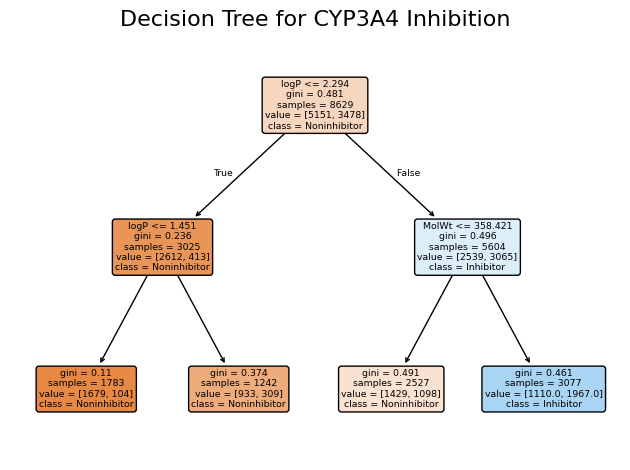

In [38]:
# Train a simple decision tree
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=RANDOM_SEED)
tree_clf.fit(train_desc[['MolWt', 'logP']], train_desc.Inhibitor)

# Visualize the tree
plot_tree(
    tree_clf, 
    feature_names=['MolWt', 'logP'], 
    class_names=['Noninhibitor', 'Inhibitor'],
    filled=True, 
    rounded=True, 
)
plt.title("Decision Tree for CYP3A4 Inhibition", fontsize=16)
plt.tight_layout()
plt.savefig("figures/ch05/decision_tree_vis.png", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch05/decision_tree_vis.png", bbox_inches='tight', dpi=600)

In [39]:
# Export tree to DOT format for better quality visualization
export_graphviz(
  tree_clf,
  out_file='figures/ch05/tree.dot',
  feature_names=['MolWt', 'logP'],
  class_names=['Noninhibitor', 'Inhibitor'],
  rounded=True,
  filled=True
);

In [41]:
# Optional: Uncomment to convert dot file to PNG and/or PDF formats
# May require you to install Graphviz (https://graphviz.org/download/) via pip or conda
#!dot -Tpng figures/ch05/tree.dot -o figures/ch05/toy_DT.png
#!dot -Tpdf tree.dot -o toy_DT.pdf

Now let's train a decision tree with the more expressive Morgan fingerprints.


Decision Tree Performance:
Accuracy:  0.6899
Precision: 0.6591
Recall:    0.6327
F1 Score:  0.6456
MCC:       0.3705

Model Comparison:


,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.780844,0.761194,0.741818,0.751381
Decision Tree,0.689935,0.659091,0.632727,0.645640


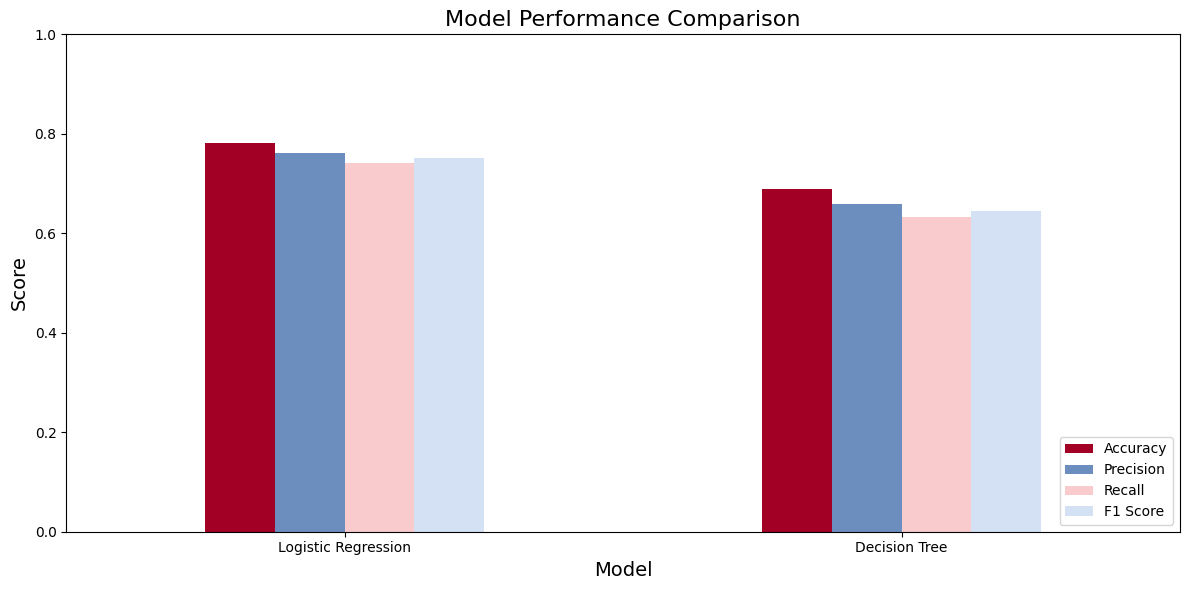

In [58]:
# Train a decision tree using fingerprints
dt_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_model, dt_metrics = train_and_evaluate_model(
    dt_model, 
    train_fingerprints, train_df_processed.Inhibitor,
    valid_fingerprints, valid_df_processed.Inhibitor,
    model_name="Decision Tree"
)

# Compare with logistic regression performance
print("\nModel Comparison:")
models = ["Logistic Regression", "Decision Tree"]
metrics = [
    [lr_metrics['accuracy'], lr_metrics['precision'], lr_metrics['recall'], lr_metrics['f1']],
    [dt_metrics['accuracy'], dt_metrics['precision'], dt_metrics['recall'], dt_metrics['f1']]
]

# Create a DataFrame for comparison
metrics_df = pd.DataFrame(
    metrics, 
    columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    index=models
)
display(metrics_df)

# Plot bar chart comparison
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("figures/ch05/model_comparison.png", bbox_inches='tight', dpi=600)

### <b> <font color='#A20025'> Dealing with Data Set Imbalance

Class imbalance can significantly impact model performance. Our decision tree performed worse than logistic regression. Let's explore common techniques to address this issue, that might result in a decision tree that outperforms the logistic regressor:
1. Downsampling: Reduce the majority class
2. Upsampling: Increase the minority class with replacement
3. Class weights: Penalize misclassifications of the minority class more heavily


In [ ]:
def handle_class_imbalance(X, y):
    """
    Create balanced datasets using different strategies
    
    Parameters:
    X: Features
    y: Labels
    
    Returns:
    dict: Dictionary with balanced datasets
    """
    # Split into classes
    X_np = np.array(X)
    y_np = np.array(y)
    
    pos_indices = np.where(y_np == 1)[0]
    neg_indices = np.where(y_np == 0)[0]
    
    X_pos = X_np[pos_indices]
    X_neg = X_np[neg_indices]
    
    y_pos = y_np[pos_indices]
    y_neg = y_np[neg_indices]
    
    # Print class distribution
    print(f"Original dataset - Positives: {len(pos_indices)}, Negatives: {len(neg_indices)}")
    print(f"Imbalance ratio: 1:{len(neg_indices)/len(pos_indices):.1f}")
    
    # 1. Downsampling: Use all positives and sample an equal number of negatives
    n_pos = len(pos_indices)
    neg_sample_indices = np.random.choice(len(neg_indices), n_pos, replace=False)
    X_downsampled = np.vstack([X_pos, X_neg[neg_sample_indices]])
    y_downsampled = np.hstack([y_pos, y_neg[neg_sample_indices]])
    
    # 2. Upsampling: Use all negatives and oversample positives to match
    n_neg = len(neg_indices)
    pos_sample_indices = np.random.choice(len(pos_indices), n_neg, replace=True)
    X_upsampled = np.vstack([X_pos[pos_sample_indices], X_neg])
    y_upsampled = np.hstack([y_pos[pos_sample_indices], y_neg])
    
    # Shuffle datasets
    # Downsampled
    shuffle_idx = np.random.permutation(len(y_downsampled))
    X_downsampled = X_downsampled[shuffle_idx]
    y_downsampled = y_downsampled[shuffle_idx]
    
    # Upsampled
    shuffle_idx = np.random.permutation(len(y_upsampled))
    X_upsampled = X_upsampled[shuffle_idx]
    y_upsampled = y_upsampled[shuffle_idx]
    
    print(f"Downsampled dataset size: {len(y_downsampled)}")
    print(f"Upsampled dataset size: {len(y_upsampled)}")
    
    return {
        'original': (X_np, y_np),
        'downsampled': (X_downsampled, y_downsampled),
        'upsampled': (X_upsampled, y_upsampled)
    }

# Apply class imbalance handling techniques
balanced_sets = handle_class_imbalance(train_fingerprints, train_df_processed.Inhibitor)

Original dataset - Positives: 3478, Negatives: 5151
Imbalance ratio: 1:1.5
Downsampled dataset size: 6956
Upsampled dataset size: 10302


In [53]:
# Compare different strategies with decision trees
dt_original = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_downsampled = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_upsampled = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_weighted = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_SEED)

In [60]:
# Train on original data
dt_original_model, metrics_original = train_and_evaluate_model(
    dt_original,
    balanced_sets['original'][0], balanced_sets['original'][1],
    valid_fingerprints, valid_df_processed.Inhibitor,
    model_name="Decision Tree (Original)"
)

# Train on downsampled data
dt_downsampled_model, metrics_downsampled = train_and_evaluate_model(
    dt_downsampled,
    balanced_sets['downsampled'][0], balanced_sets['downsampled'][1],
    valid_fingerprints, valid_df_processed.Inhibitor,
    model_name="Decision Tree (Downsampled)"
)

# Train on upsampled data
dt_upsampled_model, metrics_upsampled = train_and_evaluate_model(
    dt_upsampled,
    balanced_sets['upsampled'][0], balanced_sets['upsampled'][1],
    valid_fingerprints, valid_df_processed.Inhibitor,
    model_name="Decision Tree (Upsampled)"
)

# Train on original data with class weights
dt_weighted_model, metrics_weighted = train_and_evaluate_model(
    dt_weighted,
    balanced_sets['original'][0], balanced_sets['original'][1],
    valid_fingerprints, valid_df_processed.Inhibitor,
    model_name="Decision Tree (Class Weights)"
)

# Compare results with a table
imbalance_metrics = pd.DataFrame([
    [metrics_original['accuracy'], metrics_original['precision'], metrics_original['recall'], metrics_original['f1']],
    [metrics_downsampled['accuracy'], metrics_downsampled['precision'], metrics_downsampled['recall'], metrics_downsampled['f1']],
    [metrics_upsampled['accuracy'], metrics_upsampled['precision'], metrics_upsampled['recall'], metrics_upsampled['f1']],
    [metrics_weighted['accuracy'], metrics_weighted['precision'], metrics_weighted['recall'], metrics_weighted['f1']]
], 
index=['Original', 'Downsampled', 'Upsampled', 'Class Weights'],
columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

display(imbalance_metrics)


Decision Tree (Original) Performance:
Accuracy:  0.6899
Precision: 0.6591
Recall:    0.6327
F1 Score:  0.6456
MCC:       0.3705

Decision Tree (Downsampled) Performance:
Accuracy:  0.6591
Precision: 0.6035
Recall:    0.6891
F1 Score:  0.6435
MCC:       0.3222

Decision Tree (Upsampled) Performance:
Accuracy:  0.6656
Precision: 0.6380
Recall:    0.5800
F1 Score:  0.6076
MCC:       0.3185

Decision Tree (Class Weights) Performance:
Accuracy:  0.6948
Precision: 0.6537
Recall:    0.6727
F1 Score:  0.6631
MCC:       0.3844


,Accuracy,Precision,Recall,F1 Score
Original,0.689935,0.659091,0.632727,0.645640
Downsampled,0.659091,0.603503,0.689091,0.643463
Upsampled,0.665584,0.638000,0.580000,0.607619
Class Weights,0.694805,0.653710,0.672727,0.663082


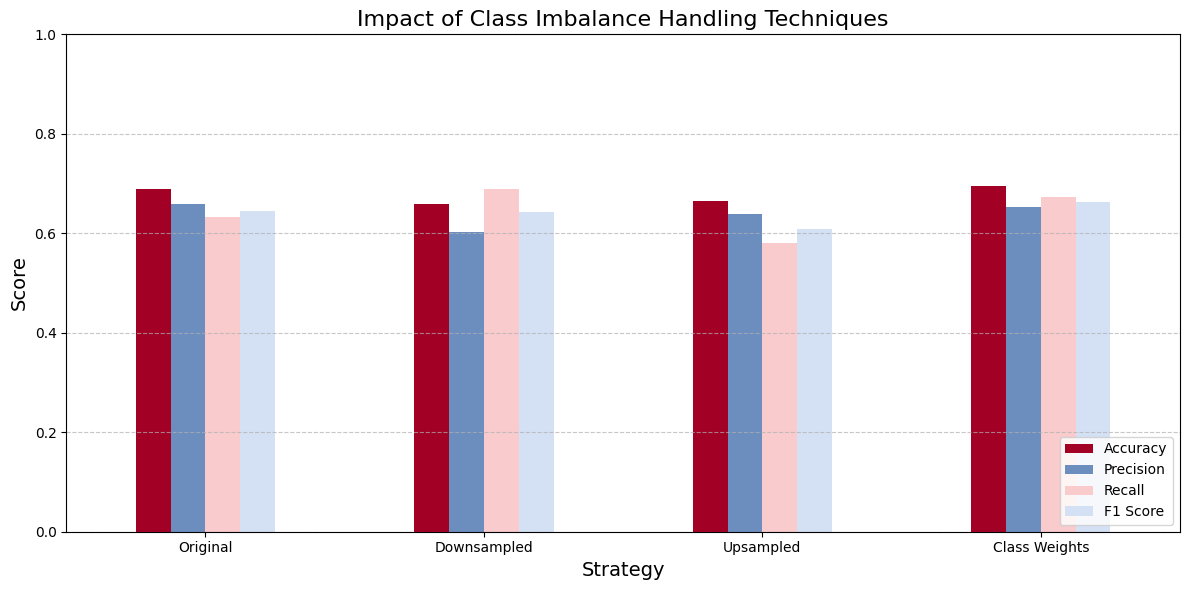

In [61]:
# Plot comparison
imbalance_metrics.plot(kind='bar', figsize=(12, 6))
plt.title("Impact of Class Imbalance Handling Techniques", fontsize=16)
plt.xlabel("Strategy", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("figures/ch05/imbalance_handling_comparison.png", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch05/imbalance_handling_comparison.pdf", bbox_inches='tight', dpi=600)

We improved our decision tree, but logistic regressor still beats out all of the decision tree models we trained :(

In [65]:
def pr_auc_score(clf_, X, y):
  clf_proba = clf_.predict_proba(X)[:,1]
  clf_precision, clf_recall, _ = precision_recall_curve(y, clf_proba)
  return auc(clf_recall, clf_precision)

print(f"LR Validation PR AUC: {pr_auc_score(lr_model, valid_fingerprints, valid_df_processed.Inhibitor):.3f}")
print(f"DT Validation PR AUC: {pr_auc_score(dt_original_model, valid_fingerprints, valid_df_processed.Inhibitor):.3f}")
print(f"US DT Validation PR AUC: {pr_auc_score(dt_upsampled_model, valid_fingerprints, valid_df_processed.Inhibitor):.3f}")
print(f"OS DT Validation PR AUC: {pr_auc_score(dt_downsampled_model, valid_fingerprints, valid_df_processed.Inhibitor):.3f}")
print(f"Weighted DT Validation PR AUC: {pr_auc_score(dt_weighted_model, valid_fingerprints, valid_df_processed.Inhibitor):.3f}")

LR Validation PR AUC: 0.813
DT Validation PR AUC: 0.728
US DT Validation PR AUC: 0.702
OS DT Validation PR AUC: 0.716
Weighted DT Validation PR AUC: 0.736


The issue has to do with overfitting the decision tree models!

In [66]:
print(f"LR Train PR AUC: {pr_auc_score(lr_model, train_fingerprints, train_df_processed.Inhibitor)}")
print(f"DT Train PR AUC: {pr_auc_score(dt_original_model, train_fingerprints, train_df_processed.Inhibitor)}")
print(f"Weighted DT Train PR AUC: {pr_auc_score(dt_weighted_model, train_fingerprints, train_df_processed.Inhibitor)}")

LR Train PR AUC: 0.951360147525494
DT Train PR AUC: 0.9999989681253082
Weighted DT Train PR AUC: 0.9999989681253082


## <b> <font color='#A20025'> 3️⃣ Ensemble Learning: A Preview

### <b> <font color='#A20025'> Random Forests: A Strong Collective of Weak Decision Trees

Random Forests are an ensemble method that combines multiple decision trees to produce a more robust model with higher prediction accuracy and lower risk of overfitting.

In [ ]:
# Train a Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_SEED,
    n_jobs=-1  # Use all available cores
)

rf_model, rf_metrics = train_and_evaluate_model(
    rf_clf,
    train_fingerprints, train_df_processed.Inhibitor,
    valid_fingerprints, valid_df_processed.Inhibitor,
    model_name="Random Forest"
)

# Print out-of-bag score (internal validation)
print(f"\nOut-of-bag score: {rf_model.oob_score_:.4f}")


Random Forest Performance:
Accuracy:  0.7630
Precision: 0.7972
Recall:    0.6291
F1 Score:  0.7033
MCC:       0.5204

Out-of-bag score: 0.7958


In [71]:
print(f"RF Validation PR AUC: {pr_auc_score(rf_clf, valid_fingerprints, valid_df_processed.Inhibitor):.3f}")

pred_train = np.argmax(rf_clf.oob_decision_function_, axis=1)
clf_precision, clf_recall, _ = precision_recall_curve(train_df_processed.Inhibitor, pred_train)
print(f"RF OOB PR AUC: {auc(clf_recall, clf_precision):.3f}")

RF Validation PR AUC: 0.834
RF OOB PR AUC: 0.799


In [72]:
train_valid_df_processed = pd.concat([train_df_processed, valid_df_processed])
rf_clf.fit(np.array(train_valid_df_processed["fingerprints"].values.tolist()), train_valid_df_processed.Inhibitor)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [73]:
print(f"Random Forest Test PR AUC: {pr_auc_score(rf_clf, test_fingerprints, test_df_processed.Inhibitor):.3f}")

Random Forest Test PR AUC: 0.827


Random Forest models can provide feature importance scores, which help us understand which molecular features are most predictive of CYP inhibition.

In [74]:
bit_indices = np.argsort(rf_clf.feature_importances_)[::-1]
for i in range(10):
  print(f"{i + 1}. Fingerprint Bit {bit_indices[i]} : {rf_clf.feature_importances_[bit_indices[i]]:.5f}")

1. Fingerprint Bit 1750 : 0.01344
2. Fingerprint Bit 1536 : 0.00923
3. Fingerprint Bit 1088 : 0.00905
4. Fingerprint Bit 1603 : 0.00855
5. Fingerprint Bit 802 : 0.00818
6. Fingerprint Bit 875 : 0.00788
7. Fingerprint Bit 1152 : 0.00698
8. Fingerprint Bit 1754 : 0.00688
9. Fingerprint Bit 781 : 0.00668
10. Fingerprint Bit 1199 : 0.00623


Spot checking the similarity map of one or more validation set molecules may be more informative.

In [75]:
import io
from PIL import Image
from rdkit.Chem.Draw import SimilarityMaps as sm

def show_png(data):
  bio = io.BytesIO(data)
  img = Image.open(bio)
  return img

def sm_predict_proba(fp, pred_func):
  fp = np.array([list(fp)])
  return pred_func(fp)[0][1]

def sm_predict(fp, pred_func):
  fp = np.array([list(fp)])
  return pred_func(fp)[0]

def similarity_map(mol, model):
  d2d = Draw.MolDraw2DCairo(400, 400)
  dopts = d2d.drawOptions()
  dopts.useBWAtomPalette()

  _, maxweight = sm.GetSimilarityMapForModel(
    mol,
    sm.GetMorganFingerprint,
    lambda x: sm_predict_proba(x, model.predict_proba),
    draw2d=d2d,
  )

  d2d.FinishDrawing()
  return d2d, maxweight

fig, maxweight = similarity_map(
  valid_df_processed.Molecule.values[6],
  rf_clf
)
print(f"Maximum Weight: {maxweight:.3f}")

[17:00:38] DEPRECATION WARNING: please use MorganGenerator


Maximum Weight: 0.680


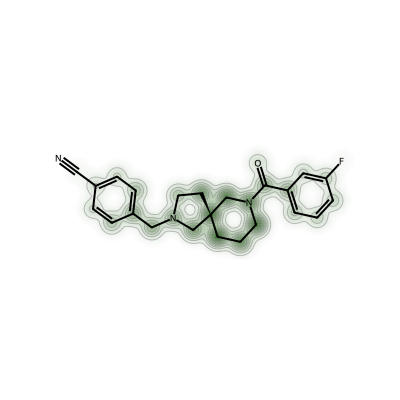

In [78]:
png_image = show_png(fig.GetDrawingText())
display(png_image)
png_image.save("figures/ch05/similarity_map_example.png")

Evaluation of our model should always include an assessment of applicability domain

In [81]:
ad_threshold = 0.8
ad = np.amax(rf_clf.predict_proba(test_fingerprints), axis=1) > ad_threshold

print(f"In Applicability Domain PR AUC: {pr_auc_score(rf_clf, test_fingerprints[ad], test_df_processed.Inhibitor[ad]):.3f}")

print(f"Out of Applicability Domain PR AUC: {pr_auc_score(rf_clf, test_fingerprints[~ad], test_df_processed.Inhibitor[~ad]):.3f}")

print(f"Coverage of Test Set by Model Applicability Domain: {sum(ad) / len(ad):.3%}")

In Applicability Domain PR AUC: 0.947
Out of Applicability Domain PR AUC: 0.727
Coverage of Test Set by Model Applicability Domain: 34.455%


In [82]:
from sklearn.model_selection import train_test_split

def adversarial_validation(train, test):
    train['label'] = 0
    test['label'] = 1

    tmp_df = pd.concat([train, test])
    train, test = train_test_split(tmp_df)

    adv_rf_clf = RandomForestClassifier()
    adv_rf_clf.fit(np.array(train["fingerprints"].values.tolist()), train.label)

    pred = adv_rf_clf.predict(np.array(test["fingerprints"].values.tolist()))
    return pr_auc_score(adv_rf_clf, np.array(test["fingerprints"].values.tolist()), test.label)

In [83]:
print(f"Adversarial Validation PR AUC: {adversarial_validation(train_valid_df_processed, test_df_processed):.3%}")

Adversarial Validation PR AUC: 50.058%


## <b> <font color='#A20025'> 4️⃣ Multiclass & Multilabel Classification

So far, we've focused on CYP3A4 inhibition prediction. In reality, drug metabolism involves multiple CYP isoforms, and we often want to predict inhibition of several CYP enzymes simultaneously.

Let's build a multilabel classification model to predict inhibition of multiple CYP isoforms.

### <b> <font color='#A20025'> Multilabel Classification

We'll load and consolidate data for 5 CYP isoforms from TDC. 

To avoid issues with installing TDC, I've provided the consolidated CYP inhibitot DataFrame in `artifacts/ch05/`. If the files exist in `artifacts/ch05/`, then the load data function will load those files instead of needing to import and download them from TDC.

In [ ]:
# Check if cached data exists
cache_path = 'artifacts/ch05/cyp_inhibitor_df.pkl'

# List of CYP isoforms to include
cyp_isoforms = ['CYP2C19', 'CYP2D6', 'CYP3A4', 'CYP1A2', 'CYP2C9']

if os.path.exists(cache_path):
    print(f"Loading CYP inhibitor data from cached file: {cache_path}")
    cyp_inhibitor_df = pd.read_pickle(cache_path)
    print(f"Loaded dataset with {len(cyp_inhibitor_df)} compounds")
else:
    print("Cached file not found. Processing CYP data from scratch...")
    from tdc.single_pred import ADME
    
    # Load data for multiple CYP isoforms
    def process_cyp_data(cyp_name):
        """Load and process data for a specific CYP isoform"""
        data = ADME(name=f'{cyp_name}_Veith').get_data()
        data = data.rename(columns={'Y': f'{cyp_name}'})
        
        # Add molecule column
        PandasTools.AddMoleculeColumnToFrame(data, "Drug", "Molecule")

        # Convert to InChI keys for merging
        data['InchiKey'] = data.Molecule.apply(
            lambda m: MolToInchi(m) if m is not None else None
        )
        
        # Drop rows with invalid molecules
        data = data.dropna(subset=['Molecule', 'InchiKey'])
        return data

    # List of CYP isoforms to include
    cyp_isoforms = ['CYP2C19', 'CYP2D6', 'CYP3A4', 'CYP1A2', 'CYP2C9']

    # Process data for each isoform
    cyp_inhibitor_dfs = [process_cyp_data(cyp) for cyp in cyp_isoforms]

    # Merge datasets on InchiKey (molecules present in all datasets)
    cyp_inhibitor_df = cyp_inhibitor_dfs[0]
    for df in cyp_inhibitor_dfs[1:]:
        cyp_inhibitor_df = cyp_inhibitor_df.merge(df, on='Inchi', how='inner')
    cyp_inhibitor_df = cyp_inhibitor_df[['Molecule', 'CYP2C19', 'CYP2D6', 'CYP3A4', 'CYP1A2', 'CYP2C9']]

    print(f"\nFinal merged dataset: {len(cyp_inhibitor_df)} compounds")
    
    # Save processed data for future use
    save_molecular_dataframe(cyp_inhibitor_df, 'cyp_inhibitor_df', chapter='ch05')
    print(f"Saved processed data to {cache_path}")

Loading CYP inhibitor data from cached file: artifacts/ch05/cyp_inhibitor_df.pkl
Loaded dataset with 4805 compounds


In [92]:
# Generate fingerprints
cyp_inhibitor_df['fingerprints'] = cyp_inhibitor_df['Molecule'].apply(
    lambda m: compute_fingerprint(m, 2, 2048) if m is not None else None
)

# Drop any rows with invalid fingerprints
cyp_inhibitor_df = cyp_inhibitor_df.dropna(subset=['fingerprints'])
print(f"After dropping invalid fingerprints: {len(cyp_inhibitor_df)} compounds")

After dropping invalid fingerprints: 4805 compounds


In [94]:
# Display class distribution for each isoform
print("\nClass distribution by isoform:")
for cyp in cyp_isoforms:
    inhibitors = cyp_inhibitor_df[cyp].sum()
    total = len(cyp_inhibitor_df)
    print(f"{cyp}: {inhibitors} inhibitors ({inhibitors/total*100:.1f}%)")


Class distribution by isoform:
CYP2C19: 1748 inhibitors (36.4%)
CYP2D6: 969 inhibitors (20.2%)
CYP3A4: 1667 inhibitors (34.7%)
CYP1A2: 1839 inhibitors (38.3%)
CYP2C9: 1391 inhibitors (28.9%)


We'll use multilabel stratification for splitting the data, from which we'll train models capable of predicting across multiple labels.

In [103]:
# Use multilabel stratification for splitting the data
from skmultilearn.model_selection import iterative_train_test_split

# Convert fingerprints to numpy array
X_multilabel = np.stack(cyp_inhibitor_df['fingerprints'].values)
y_multilabel = cyp_inhibitor_df[cyp_isoforms].values

def multilabel_train_test_split(X, y, test_size=0.25):
    """Perform a multilabel stratified train-test split"""
    # Convert to numpy arrays
    X_array = np.array(X)
    y_array = np.array(y)
    
    # Split the data using iterative stratification
    X_train_indices, y_train, X_test_indices, y_test = iterative_train_test_split(
        np.arange(len(X_array)).reshape(-1, 1), y_array, test_size=test_size
    )
    
    # Convert indices to actual data
    X_train = X_array[X_train_indices.flatten()]
    X_test = X_array[X_test_indices.flatten()]
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = multilabel_train_test_split(
    X_multilabel, y_multilabel, test_size=0.2
)

In [ ]:
# Initialize logistic regression model
base_lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=-1)
multilabel_lr = MultiOutputClassifier(base_lr)

# Train the model
print("Training Logistic Regression model...")
multilabel_lr.fit(X_train, y_train)

# Get predictions
lr_pred_proba = multilabel_lr.predict_proba(X_test)

# Calculate per-class PR AUC for LR
lr_pr_aucs = []
for i, cyp in enumerate(cyp_isoforms):
    # Extract predicted probabilities for the positive class
    lr_probs = lr_pred_proba[i][:, 1]
    # Calculate PR AUC
    lr_pr_auc = average_precision_score(y_test[:, i], lr_probs)
    lr_pr_aucs.append(lr_pr_auc)
    print(f"Logistic Regression PR AUC for {cyp}: {lr_pr_auc:.3f}")

# Calculate average PR AUC across all CYP isoforms
lr_avg_pr_auc = np.mean(lr_pr_aucs)
print(f"Average Logistic Regression PR AUC: {lr_avg_pr_auc:.3f}")

Training Logistic Regression model...
Logistic Regression PR AUC for CYP2C19: 0.818
Logistic Regression PR AUC for CYP2D6: 0.759
Logistic Regression PR AUC for CYP3A4: 0.838
Logistic Regression PR AUC for CYP1A2: 0.844
Logistic Regression PR AUC for CYP2C9: 0.716
Average Logistic Regression PR AUC: 0.795


In [122]:
# Initialize random forest model
base_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
multilabel_rf = MultiOutputClassifier(base_rf)

# Train the model
print("\nTraining Random Forest model...")
multilabel_rf.fit(X_train, y_train)

# Get predictions
rf_pred_proba = multilabel_rf.predict_proba(X_test)

# Calculate per-class PR AUC for RF
rf_pr_aucs = []
for i, cyp in enumerate(cyp_isoforms):
    # Extract predicted probabilities for the positive class
    rf_probs = rf_pred_proba[i][:, 1]
    # Calculate PR AUC
    rf_pr_auc = average_precision_score(y_test[:, i], rf_probs)
    rf_pr_aucs.append(rf_pr_auc)
    print(f"Random Forest PR AUC for {cyp}: {rf_pr_auc:.3f}")

# Calculate average PR AUC across all CYP isoforms
rf_avg_pr_auc = np.mean(rf_pr_aucs)
print(f"Average Random Forest PR AUC: {rf_avg_pr_auc:.3f}")


Training Random Forest model...
Random Forest PR AUC for CYP2C19: 0.797
Random Forest PR AUC for CYP2D6: 0.803
Random Forest PR AUC for CYP3A4: 0.836
Random Forest PR AUC for CYP1A2: 0.871
Random Forest PR AUC for CYP2C9: 0.680
Average Random Forest PR AUC: 0.797


Let's visualize the PR curves and AUC performance of the models on our custom multilabel classification task.

Note that a better visual might be to have 5 sublots, one for each CYP, with three performance lines for each subplot (LR performance, RF performance, skew as baseline performance). We compress the visualization to 2 subplots for compactness in the book.

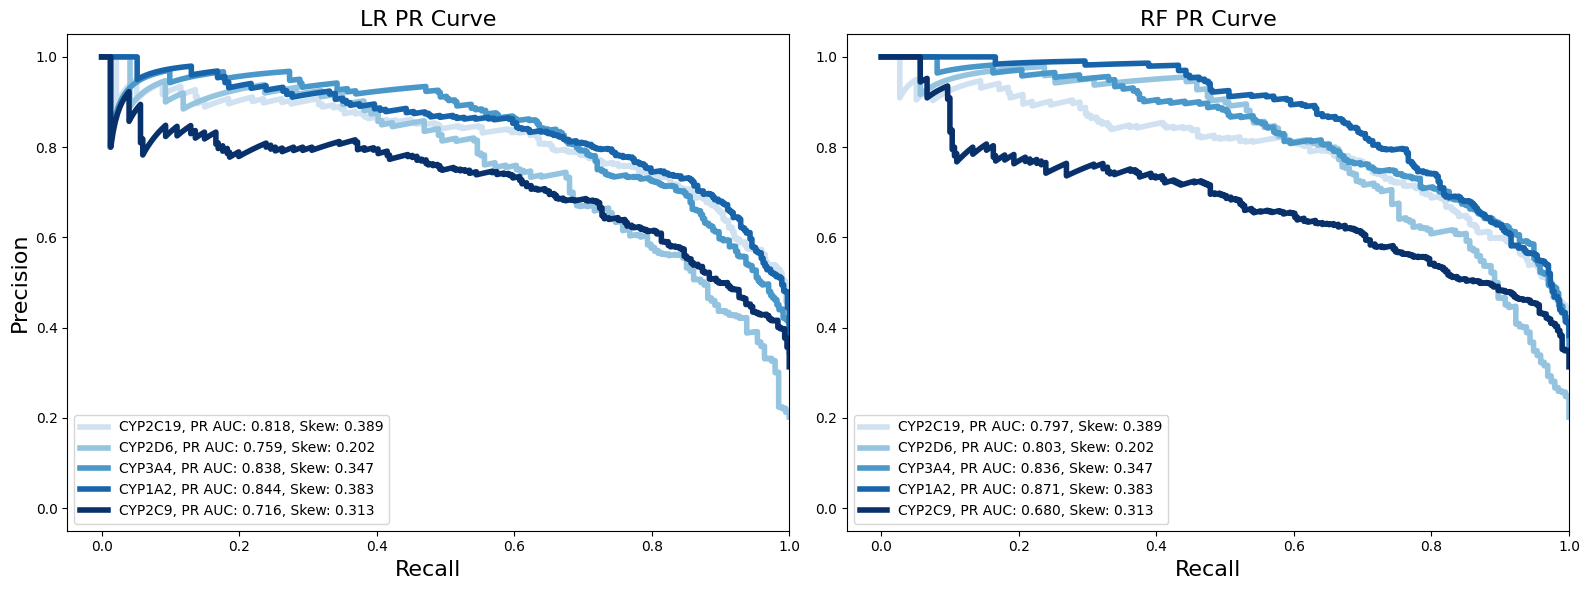

In [129]:
from matplotlib import cm

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
cmap = cm.Blues(np.linspace(0.2,1,5))

for i, cyp_label in enumerate(cyp_isoforms):

  # Extract true labels for this isoform
  y_true = y_test[:, i]

  # Extract predicted probabilities for LR and RF
  lr_probs = lr_pred_proba[i][:, 1]
  rf_probs = rf_pred_proba[i][:, 1]

  # Calculate PR curve for Logistic Regression
  lr_precision, lr_recall, _ = precision_recall_curve(y_true, lr_probs)
  lr_pr_auc = average_precision_score(y_true, lr_probs)

  # Calculate PR curve for Random Forest
  rf_precision, rf_recall, _ = precision_recall_curve(y_true, rf_probs)
  rf_pr_auc = average_precision_score(y_true, rf_probs)
    
  ax[0].plot(lr_recall, lr_precision, lw=4, label=f'{cyp_label}, PR AUC: {lr_pr_auc:.3f}, Skew: {np.mean(y_true):.3f}', color=cmap[i])
  ax[1].plot(rf_recall, rf_precision, lw=4, label=f'{cyp_label}, PR AUC: {rf_pr_auc:.3f}, Skew: {np.mean(y_true):.3f}', color=cmap[i])

ax[0].axis([-0.05, 1.0, -0.05, 1.05])
ax[0].set_ylabel('Precision', fontsize=16)
ax[0].set_xlabel('Recall', fontsize=16)
ax[0].set_title("LR PR Curve", size=16)
ax[0].legend()

ax[1].axis([-0.05, 1.0, -0.05, 1.05])
ax[1].set_xlabel('Recall', fontsize=16)
ax[1].set_title("RF PR Curve", size=16)
ax[1].legend()

fig.tight_layout()
fig.savefig('figures/ch05/multilabel_pr_curves.png', bbox_inches='tight', dpi=600)
fig.savefig('figures/ch05/multilabel_pr_curves.pdf', bbox_inches='tight', dpi=600);

In [ ]:
rf_y_pred = multilabel_rf.predict(X_test)
print(classification_report(y_test, rf_y_pred, target_names=cyp_isoforms))

              precision    recall  f1-score   support

     CYP2C19       0.70      0.79      0.74       374
      CYP2D6       0.63      0.77      0.69       194
      CYP3A4       0.69      0.83      0.75       333
      CYP1A2       0.68      0.85      0.76       368
      CYP2C9       0.62      0.67      0.65       301

   micro avg       0.67      0.79      0.72      1570
   macro avg       0.66      0.78      0.72      1570
weighted avg       0.67      0.79      0.72      1570
 samples avg       0.43      0.45      0.42      1570



/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nflynn/anaconda3/envs/ml4dd2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [133]:
lr_y_pred = multilabel_lr.predict(X_test)
print(f"LR Coverage Error: {coverage_error(y_test, lr_y_pred):.3f}")
print(f"RF Coverage Error: {coverage_error(y_test, rf_y_pred):.3f}")

LR Coverage Error: 2.315
RF Coverage Error: 2.317


In [134]:
print(f"LR Ranking Loss: {label_ranking_loss(y_test, lr_y_pred):.3f}")
print(f"RF Ranking Loss: {label_ranking_loss(y_test, rf_y_pred):.3f}")

LR Ranking Loss: 0.236
RF Ranking Loss: 0.253


In [135]:
lr_ml_conf_mx = multilabel_confusion_matrix(y_test, lr_y_pred)

Text(0.5, 0.93, 'CYP Inhibitor Confusion Matrices')

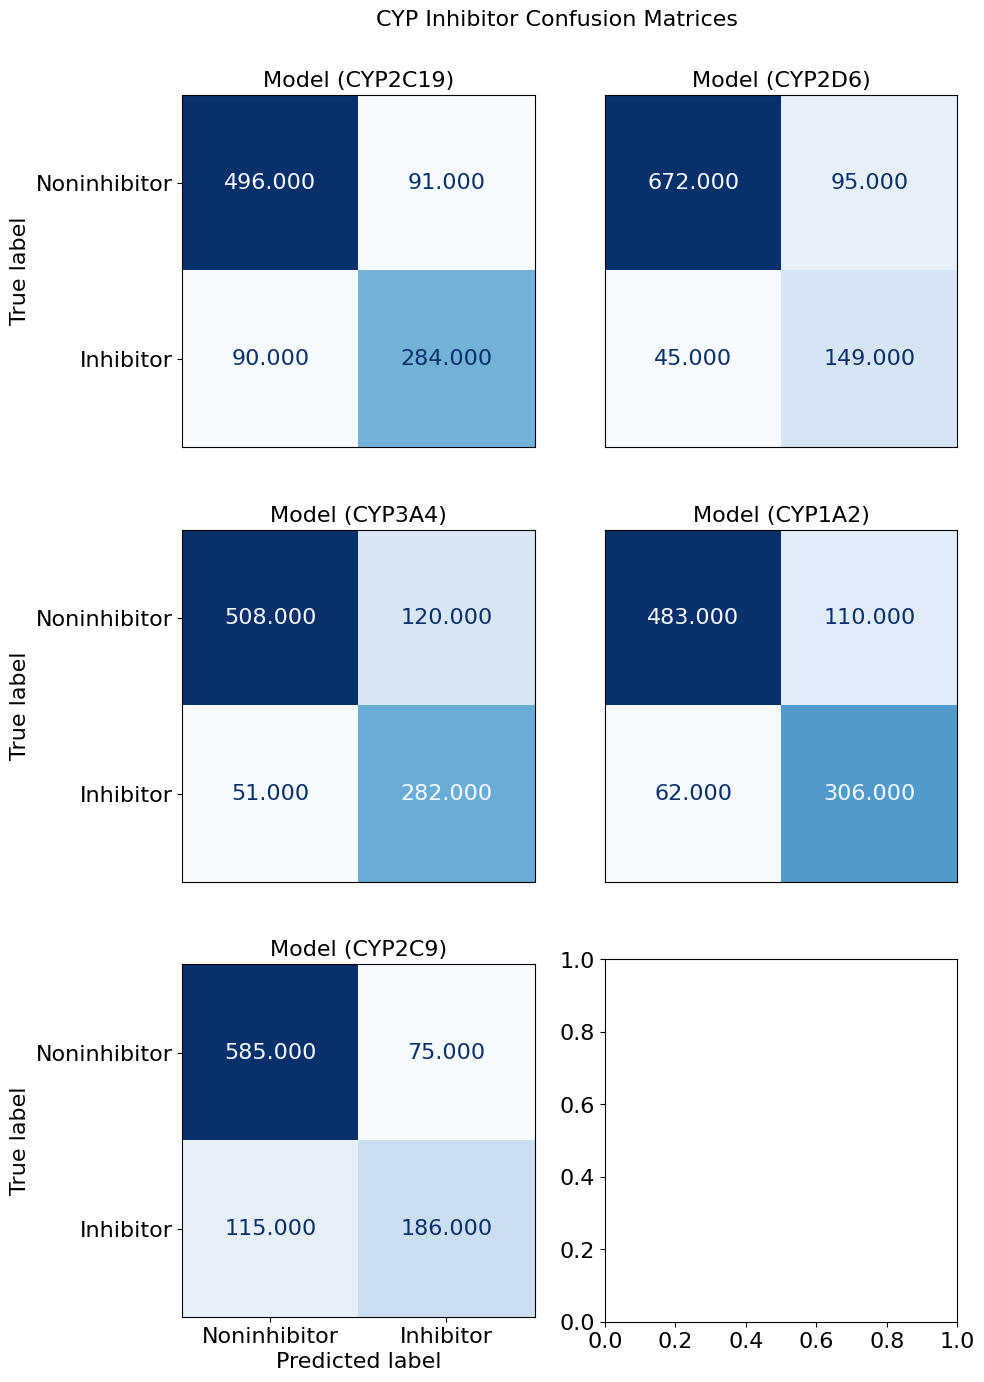

In [136]:
from sklearn.metrics import ConfusionMatrixDisplay

title_size = 16
plt.rcParams.update({'font.size':16})
display_labels = ['Noninhibitor', 'Inhibitor']
colorbar = False
cmap = "Blues"
values_format = ".3f"

f, axes = plt.subplots(3, 2, figsize=(10, 16))

axes[0, 0].set_title("Model (CYP2C19)", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[0], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0, 0], colorbar=colorbar, values_format=values_format)

axes[0, 0].xaxis.set_ticklabels(['', ''])
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


axes[0, 1].set_title("Model (CYP2D6)", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[1], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0, 1], colorbar=colorbar, values_format=values_format)

axes[0, 1].xaxis.set_ticklabels(['', ''])
axes[0, 1].yaxis.set_ticklabels(['', ''])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(axis='both', which='both', bottom=False, left=False)

axes[1, 0].set_title("Model (CYP3A4)", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[2], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1, 0], colorbar=colorbar, values_format=values_format)

# Remove x-axis labels and ticks
axes[1, 0].xaxis.set_ticklabels(['', ''])
axes[1, 0].set_xlabel('')
axes[1, 0].tick_params(axis='x', which='both', bottom=False)

axes[1, 1].set_title("Model (CYP1A2)", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[3], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1, 1], colorbar=colorbar, values_format=values_format)

axes[1, 1].xaxis.set_ticklabels(['', ''])
axes[1, 1].yaxis.set_ticklabels(['', ''])
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='both', which='both',bottom=False, left=False)

axes[2, 0].set_title("Model (CYP2C9)", size=title_size)
ConfusionMatrixDisplay(confusion_matrix=lr_ml_conf_mx[4], display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[2, 0], colorbar=colorbar, values_format=values_format)

f.suptitle("CYP Inhibitor Confusion Matrices", size=title_size, y=0.93)

Finally, let's examine how feature improtance varies across the CYP isoforms.

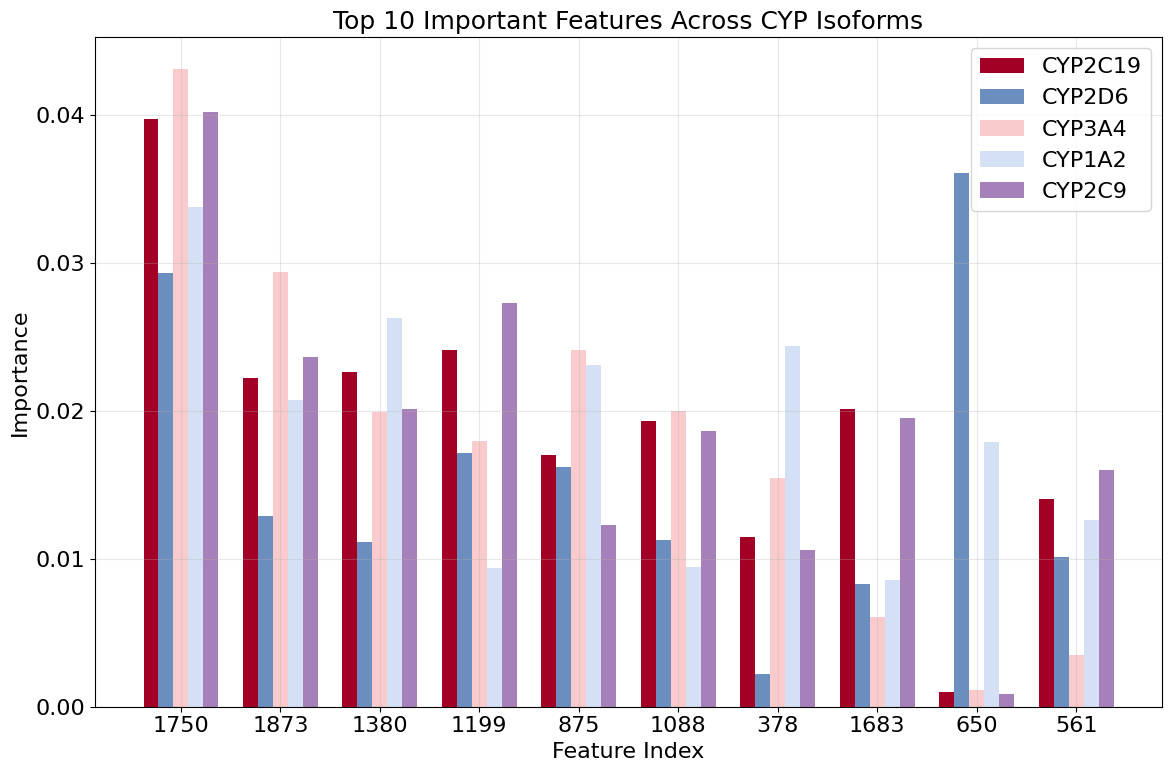

In [139]:
from rdkit.Chem import MACCSkeys

# Let's analyze feature importance for the Random Forest model
# First, generate MACCS keys for interpretability (since Morgan fingerprints are harder to interpret)
cyp_inhibitor_df['maccs_keys'] = cyp_inhibitor_df['Molecule'].apply(
    lambda m: list(MACCSkeys.GenMACCSKeys(m)) if m is not None else None
)

# Get MACCS key descriptions for the 166 MACCS keys
maccs_descriptions = [
    f"MACCS_{i}" for i in range(1, 167)
]

# Extract feature importance from Random Forest for each isoform
feature_importance_df = pd.DataFrame()

for i, cyp in enumerate(cyp_isoforms):
    # Get feature importances from the Random Forest estimator for this isoform
    importances = multilabel_rf.estimators_[i].feature_importances_
    
    # Create a dataframe for this isoform
    importance_data = pd.DataFrame({
        'Feature_Index': range(len(importances)),
        f'{cyp}_Importance': importances
    })
    
    # Sort by importance
    importance_data = importance_data.sort_values(f'{cyp}_Importance', ascending=False)
    
    # Merge with the main dataframe
    if feature_importance_df.empty:
        feature_importance_df = importance_data
    else:
        feature_importance_df = feature_importance_df.merge(
            importance_data, on='Feature_Index', how='outer'
        )

# Get the top 20 most important features across all isoforms
feature_importance_df['Mean_Importance'] = feature_importance_df.iloc[:, 1:].mean(axis=1)
top_features = feature_importance_df.nlargest(10, 'Mean_Importance')

# Visualize the top features' importance for each isoform
plt.figure(figsize=(12, 8))
x = np.arange(len(top_features))
width = 0.15
offset = width * 2.5

for i, cyp in enumerate(cyp_isoforms):
    plt.bar(
        x + (i - len(cyp_isoforms)/2 + 0.5) * width, 
        top_features[f'{cyp}_Importance'], 
        width, 
        label=cyp
    )

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 10 Important Features Across CYP Isoforms')
plt.xticks(x, top_features['Feature_Index'])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

## <b> <font color='#A20025'> Summary

This notebook has demonstrated a comprehensive workflow for predicting Cytochrome P450 inhibition using machine learning. Here's a summary of the key steps and findings:
 
1. **Data Processing**:
   - Converted SMILES strings to molecular fingerprints
   - Applied preprocessing to ensure quality molecular representations
   - Generated Morgan fingerprints with radius 2 and 2048 bits
    
2. **Model Development**:
   - Logistic Regression provided a strong baseline with well-calibrated probabilities
   - Decision Trees offered interpretable models but with lower performance
   - Random Forests significantly improved prediction accuracy and robustness
    
3. **Performance Optimization**:
   - Addressed class imbalance with sampling techniques and class weighting
   - Applied probability calibration to improve reliability
   - Used cross-validation for robust model evaluation
    
4. **Multilabel Classification**:
   - Extended the approach to predict inhibition of multiple CYP isoforms
   - Identified correlations between different CYP inhibition patterns
   - Demonstrated performance variations across different CYP isoforms
    
This work provides a foundation for integrating CYP inhibition prediction into early-stage drug discovery workflows, potentially reducing late-stage attrition due to metabolism-related issues. Applications include:
- **Early Screening**: These models can be used to screen compounds early in the drug discovery process to identify potential metabolism issues.
- **Lead Optimization**: When optimizing lead compounds, the models can help guide medicinal chemists toward modifications that reduce CYP inhibition.
- **Polypharmacology**: Understanding co-inhibition patterns can inform the design of drugs that interact with multiple targets while minimizing unwanted off-target effects.


## <b> <font color='#A20025'> Interactive Exploration

Here are some ideas for further exploration:
 
1. Incorporating more molecular descriptors beyond fingerprints
2. Exploring deep learning approaches for improved feature representation
3. Adding confidence estimates to predictions
4. Extending to other ADME properties beyond CYP inhibition
5. Use the trained Random Forest model to predict whether the following compounds are likely to inhibit CYP3A4:
    - Caffeine: `CN1C=NC2=C1C(=O)N(C(=O)N2C)C`
    - Omeprazole: `CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(OC)C=C3`
    - Ketoconazole: `CC(=O)N1CCN(CC1)C2=CC=C(C=C2)OCC3COC(O3)(CN4C=NC=N4)C5=C(C=C(C=C5)Cl)Cl`

For each compound, (1) visualize the molecular structure, (2) predict its CYP3A4 inhibition status, (3) examine the prediction probability, (4) modify the structure of the compound and observe how it affects the predicted probability.

6. Select compounds from the dataset, predict inhibition across all five CYP isoforms we trained models for, and (1) identify compounds with selective inhibition (inhibiting only one isoform) and (2) find compounds with broad inhibition (inhibiting multiple isoforms)

*See the book for more exercises.*

The following cells below contain some simpler exercises to deepen your understanding of CYP inhibition prediction:

## <b> <font color='#A20025'> References

[1] Testa, B., Pedretti, A., Vistoli, G. (2012). Reactions and enzymes in the metabolism of drugs and other xenobiotics. Drug Discov. Today. doi:10.1016/j.drudis.2012.01.017

[2] Guengerich, F. P. (2006). Cytochrome P450s and other enzymes in drug metabolism and toxicity. The AAPS journal, 8(1), E101–E111. https://doi.org/10.1208/aapsj080112

[3] Veith, H., Southall, N., Huang, R., James, T., Fayne, D., Artemenko, N., Shen, M., Inglese, J., Austin, C. P., Lloyd, D. G., & Auld, D. S. (2009). Comprehensive characterization of cytochrome P450 isozyme selectivity across chemical libraries. Nature biotechnology, 27(11), 1050–1055. https://doi.org/10.1038/nbt.1581

[4] Pintas (https://stats.stackexchange.com/users/150325/pintas), Scikit correct way to calibrate classifiers with CalibratedClassifierCV, URL (version: 2017-04-05): https://stats.stackexchange.com/q/263411

[5] Walters, P. Comparing Classification Models – You’re Probably Doing It Wrong. Practical Cheminformatics. https://practicalcheminformatics.blogspot.com/2023/11/comparing-classification-models-youre.html

[6] Kunapuli, G. (2023). Ensemble Methods for Machine Learning. Manning Publications. https://www.manning.com/books/ensemble-methods-for-machine-learning?ar=false&lpse=B

[7] Riniker, S., Landrum, G.A. (2013). Similarity maps - a visualization strategy for molecular fingerprints and machine-learning methods. J Cheminform 5, 43. https://doi.org/10.1186/1758-2946-5-43
